In [429]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

<Axes: >

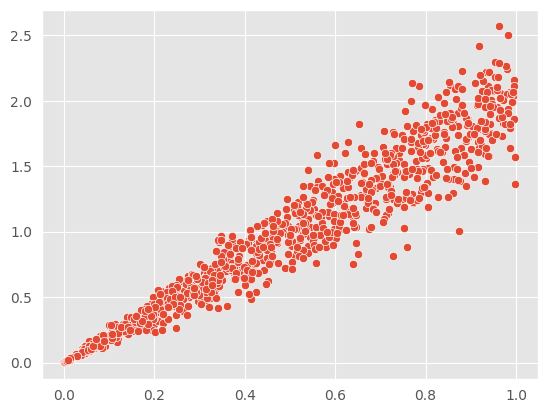

In [430]:
# Random dataset sampled from a gaussian distribution.
x = np.random.uniform(0,1, size = (1000,))
y = x * 2 + x * np.random.normal(0, 0.3, size = (1000,))

df = pd.DataFrame({'x': x,'y':y})

sns.scatterplot(df, x= x, y = y)

In [431]:
class LogisticRegressionModel(nn.Module):
  @nn.compact
  def __call__(self, x):
    assert x.shape[0] == 1
    # f = nn.Dense(features=512)(xy)
    # f = nn.relu(f)
    f = x
    return nn.Dense(features=1)(f)

model = LogisticRegressionModel()

params = model.init(jax.random.PRNGKey(45), jnp.array([1.]))

In [432]:
def loss(params, apply_fn, x, y):
  """Binary cross entropy."""
  logit = apply_fn(params, x)
  return jnp.mean(optax.losses.l2_loss(logit, y))

In [433]:
value_and_grad = jax.value_and_grad(loss)
value_and_grad_vectorized = jax.vmap(value_and_grad, in_axes = (jax.tree_util.tree_map(lambda x: None, params),None, 0,0))

optimizer = optax.sgd(learning_rate = 0.1)
optimizer_state = optimizer.init(params)

def update_weights(params, optimizer_state, x, y,  apply_fn, optimizer):
  loss, grad = value_and_grad_vectorized(params, apply_fn, x[:, None], y[:, None])
  loss = jnp.mean(loss)
  grad = jax.tree_util.tree_map(jnp.mean, grad)
  weight_updates, new_states =  optimizer.update(grad, optimizer_state)
  new_params = optax.apply_updates(params, weight_updates)
  return new_params, new_states , loss

In [434]:
optimizer = optax.sgd(learning_rate = 0.3)
optimizer_state = optimizer.init(params)

def train_epoch(params, optimizer_state):
  new_params, new_states, l = update_weights(params,
                                          optimizer_state,
                                          df.x.values,
                                          df.y.values,
                                          model.apply,
                                          optimizer)
  logits = jax.vmap(model.apply, in_axes=[None, 0])(new_params, df.x.values[:, None])
  l2 = jnp.mean(optax.l2_loss(logits, df.y.values[:, None]))
  return new_params, new_states, l, l2

Text(0.5, 1.0, 'Before Training')

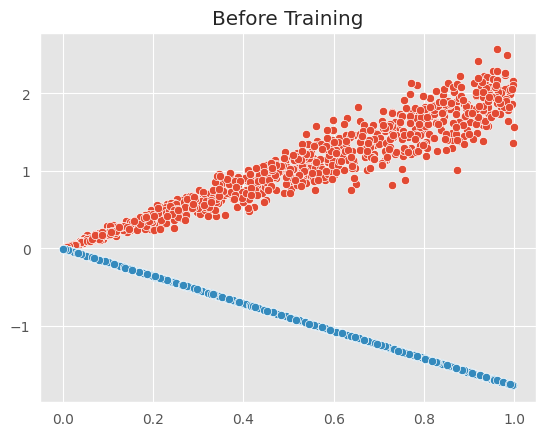

In [435]:
def plot_result(ax, params, epoch, l2, loss):
  sampled_x = jax.random.uniform(jax.random.key(0), shape=(1000,1)) * (x.max() - x.min()) + x.min()
  pred_y = jax.vmap(model.apply, in_axes=[None, 0])(params, sampled_x)
  
  sns.scatterplot(df, x= x, y = y, ax = ax)
  sns.scatterplot(x= sampled_x.squeeze(), y = pred_y.squeeze(), ax = ax)
  ax.set_title(f'Epoch: {epoch} : l2: {l2:.2f}, loss:{loss:.2f}', fontsize = 10)
fig, ax = plt.subplots(1,1,)
plot_result(ax, params, 0,0,0)
ax.set_title('Before Training')

  0%|          | 0/1000 [00:00<?, ?it/s]

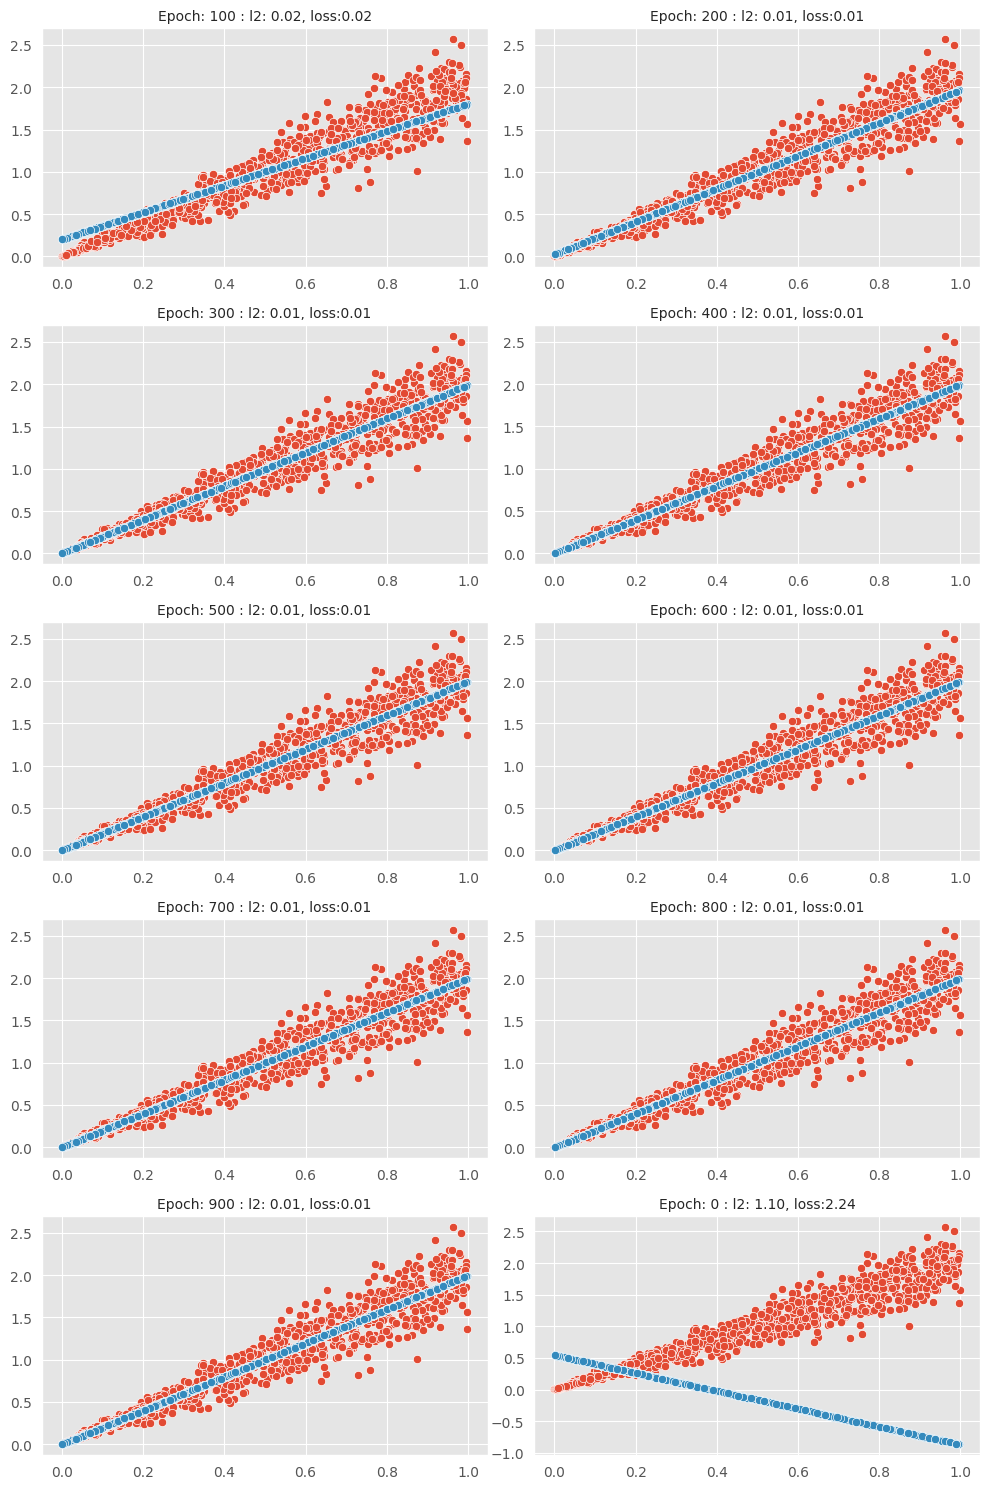

In [436]:
from tqdm.auto import trange
epochs = 1000

fig, axes = plt.subplots(5,2, figsize = (10,15))
axes = axes.flatten()
for epoch in trange(0, epochs):
  params, optimizer_states, l, l2 = train_epoch(params, optimizer_state)
  if epoch % 100 == 0:
    plot_result(axes[epoch//100-1], params, epoch, l2, l)
plt.tight_layout()

In [437]:
params

{'params': {'Dense_0': {'bias': Array([-0.00466004], dtype=float32),
   'kernel': Array([[1.9987035]], dtype=float32)}}}